### Example 12 - Finding Bid Targets

In this example, we'll attempt to find good candidates for placing bid limit orders in the hope of generating profitable scrapmetal arbitrage opportunities.  We demonstrate the search for these candidates by running a back test on a single day of market data, similar to our search in Example 9.  If you recall, that example required significant time to execute due to the large number of asset types eligible for scrapmetal processing.  In this example, however, we'll only search asset types which are likely to be good limit order targets.  That is, we will pre-filter for assets which are:

* liquid, as defined below; and,
* at least 30% of inferred trades are sells.

The first part of this example will focus on filtering scrapmetal eligible asset types according to this criteria.  The second part of the example will then evaluate these types to determine whether the best bid is close enough to a target price we need to hit in order to be profitable.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time

In [2]:
# As in previous examples, we'll consider opportunities in The Forge at the busiest station in Jita.
sde_client = Client.SDE.get()
region_query = "{values: ['The Forge']}"
station_query = "{values: ['Jita IV - Moon 4 - Caldari Navy Assembly Plant']}"
region_id = sde_client.Map.getRegions(regionName=region_query).result()[0][0]['regionID']
station_id = sde_client.Station.getStations(stationName=station_query).result()[0][0]['stationID']
compute_date = datetime.datetime(2017, 1, 10)
print("Using region_id=%d, station_id=%d at %s" % (region_id, station_id, str(compute_date)))

Using region_id=10000002, station_id=60003760 at 2017-01-10 00:00:00


In [3]:
# Now retrieve scrapmetal processing eligible types
material_map = {}
source_types = {}
for next_type in Client.SDE.load_complete(sde_client.Inventory.getTypeMaterials):
    typeID = next_type['typeID']
    if typeID not in material_map.keys():
        material_map[typeID] = {}
    material_map[typeID][next_type['materialTypeID']] = next_type
#
# and resolve type information
#
type_list = list(material_map.keys())
for i in range(0, len(type_list), 100):
    next_batch = type_list[i:min(i+100, len(type_list))]
    type_query = "{values:[" + ",".join([str(x) for x in next_batch]) + "]}"
    for next_type in Client.SDE.load_complete(sde_client.Inventory.getTypes, typeID=type_query):
        typeID = next_type['typeID']
        source_types[typeID] = next_type
        source_types[typeID]['material_map'] = material_map[typeID]
#
# Finally, remove the ore and ice types from the source types
#
material_group_names = [ 'Veldspar', 'Scordite', 'Pyroxeres', 'Plagioclase', 'Omber', 'Kernite', 'Jaspet', 
                         'Hemorphite', 'Hedbergite', 'Gneiss', 'Dark Ochre', 'Spodumain', 'Crokite', 
                         'Bistot', 'Arkonor', 'Mercoxit', 'Ice' ]
group_name_query = "{values:[" + ",".join(map(lambda x : "'" + x + "'", material_group_names)) + "]}"
material_groups = Client.SDE.load_complete(sde_client.Inventory.getGroups, groupName=group_name_query)
group_id_query = "{values:[" + ",".join([str(x['groupID']) for x in material_groups]) + "]}"
for next_type in Client.SDE.load_complete(sde_client.Inventory.getTypes, groupID=group_id_query):
    if next_type['typeID'] in source_types.keys():
        del source_types[next_type['typeID']]

In [4]:
# Now we'll load market history for the date range.  It is strongly suggested that you download data
# to local storage first.  The code below assumes you've done that.  If you'd prefer to skip the 
# download and use online sources, you can remove the "local_storage" parameter from below.
#
# We're using a date range for the last 90 days up to the day before our target date.  This reflects
# the fact that market history would not be available for the current day and therefore shouldn't
# be included in our liquidity filter.
#
from evekit.marketdata import MarketHistory
date_range = pd.date_range(compute_date - datetime.timedelta(days=90), compute_date - datetime.timedelta(days=1))
market_history = MarketHistory.get_data_frame(dates=date_range, types=source_types.keys(), regions=[region_id], 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2016-10-12 00:00:00...done
Retrieving 2016-10-13 00:00:00...done
Retrieving 2016-10-14 00:00:00...done
Retrieving 2016-10-15 00:00:00...done
Retrieving 2016-10-16 00:00:00...done
Retrieving 2016-10-17 00:00:00...done
Retrieving 2016-10-18 00:00:00...done
Retrieving 2016-10-19 00:00:00...done
Retrieving 2016-10-20 00:00:00...done
Retrieving 2016-10-21 00:00:00...done
Retrieving 2016-10-22 00:00:00...done
Retrieving 2016-10-23 00:00:00...done
Retrieving 2016-10-24 00:00:00...done
Retrieving 2016-10-25 00:00:00...done
Retrieving 2016-10-26 00:00:00...done
Retrieving 2016-10-27 00:00:00...done
Retrieving 2016-10-28 00:00:00...done
Retrieving 2016-10-29 00:00:00...done
Retrieving 2016-10-30 00:00:00...done
Retrieving 2016-10-31 00:00:00...done
Retrieving 2016-11-01 00:00:00...done
Retrieving 2016-11-02 00:00:00...done
Retrieving 2016-11-03 00:00:00...done
Retrieving 2016-11-04 00:00:00...done
Retrieving 2016-11-05 00:00:00...done
Retrieving 2016-11-06 00:00:00...done
Retrieving 2

In [5]:
# Since our first task will be to filter for liquidity, we need our liquidity filter
# framework from the first chapter.  Here it is again.  Consult the documentation
# in the previous example as needed.
#
def liquid_types(history, liquidp, verbose=False):
    # Result is map from region to set of liquid types for that region
    # Iterate through all types contained in the history object
    liquid_map = {}
    count = 0
    # Iterate through all regions and types
    for next_region in history.region_id.unique():
        liquid_set = set()
        by_region = history[history.region_id == next_region]
        for next_type in by_region.type_id.unique():
            by_type = by_region[by_region.type_id == next_type]
            if liquidp(next_region, next_type, by_type):
                liquid_set.add(next_type)
            count += 1
            if count % 1000 == 0 and verbose:
                print("Tested %d (region, type) pairs" % count)
        liquid_map[next_region] = liquid_set
    return liquid_map

In [6]:
# Our liquidity filter for this example will be defined as follows:
#
# 1. Market history must exist for a minimum number of days
# 2. Average ISK volume must exceed a threshold
# 3. Volume must exceed a certain threshold
#
# The following functor will generate the required filter.
#
def liquidity_filter(min_days, min_isk_volume, min_volume):
    def liquidp(region_id, type_id, history):
        return len(history) >= min_days and \
               len(history[(history.avg_price * history.volume) < min_isk_volume]) == 0 and \
               len(history[history.volume < min_volume]) == 0
    return liquidp

In [7]:
# We'll use the following values to parameterize the liquidity filter
#
# Minimum number of units exchanged per day
min_volume = 1000
# Minimum daily trade volume (avg. price * volume) per day
min_volume_isk = 100000000
# Each type we consider must have at least this many days worth of history
min_values = len(market_history.index.unique()) - 2
#
# These liquidity settings make it likely that enough interesting volume is 
# traded in a given day for profitability (assuming enough orders are also
# sells into the best bid).

In [8]:
# Now we can go ahead and compute the liquid types among the set of scrapmetal
# processing eligible types.  As you may recall, the result will be a map
# from region to the set of liquid types in that region.
#
liquid_type_map = liquid_types(market_history, liquidity_filter(min_values, min_volume_isk, min_volume))
len(liquid_type_map[region_id])

130

In [9]:
# Our next step is to infer trades for our liquid types from a day of market data.  We're doing
# this to determine how many trades are sells into the best bid.  Note that we only need to 
# load market data for the liquid types and the refined materials they product, so this should 
# go much faster.
#
from evekit.marketdata import OrderBook
required_types = set(liquid_type_map[region_id])
for next_type in liquid_type_map[region_id]:
    required_types = required_types.union(source_types[next_type]['material_map'].keys())
order_book = OrderBook.get_data_frame(dates=[compute_date], types=required_types, regions=[region_id], 
                                      config=dict(local_storage=".", tree=True, skip_missing=True, 
                                                  fill_gaps=True, verbose=True))

Retrieving 2017-01-10 00:00:00...done


In [12]:
# We'll use a slightly modified version of our trade inferrer from Example 4.
# This version uses market history to compute a volume threshold 
# based on a rolling average of recent history over a five day window.  We use
# this threshold to decide whether removed orders represent fills (orders
# with sizes below the threshold) or cancels (orders with sizes above the
# threshold).
#
def infer_trades(type_set, order_book, market_history):
    inferred_trades = []
    # Compute per-type volume threshold
    volume_threshold_map = {}
    threshold_ratio = 0.04
    for next_type in type_set:
        by_type = market_history[market_history.type_id == next_type]
        thresh_series = by_type.volume.rolling(window=5, center=False).mean()
        volume_threshold_map[next_type] = thresh_series[-1] * threshold_ratio
    # We need to iterate over consecutive order book snapshots looking for changes between snapshots.
    # To do this, we'll group by snapshot time as we did in Example 2, then iterate over 
    # consecutive pairs of groups.
    snap_list = list(order_book.groupby(order_book.index))
    snap_pairs = zip(snap_list, snap_list[1:])
    for current, next in snap_pairs:
        current_snap = current[1]
        next_snap = next[1]
        # First, look for orders present in both snapshots but have their volume changed
        merged = pd.merge(current_snap, next_snap, on="order_id")
        changed_orders = merged[merged.volume_x != merged.volume_y]
        for next_change in changed_orders.index:
            # Create the trade object
            next_line = changed_orders.ix[next_change]
            if next_line.type_id_x not in type_set:
                continue
            amount = next_line.volume_x - next_line.volume_y 
            location = next_line.location_id_x
            if next_line.buy_x and next_line.order_range_x != 'station':
                # For buy orders, we can't be certain where the trade occurred unless the buy is limited to a station
                location = None
            inferred_trades.append({
                'timestamp': next[0],
                'type_id': next_line.type_id_x,
                'actual': True,
                'buy': next_line.buy_x, 
                'order_id': next_line.order_id, 
                'price': next_line.price_y,
                'volume': amount, 
                'location': str(location)})                
        # Second, look for orders which are removed between snapshots.
        removed_orders = set(current_snap.order_id).difference(set(next_snap.order_id))
        for order_id in removed_orders:
            next_line = current_snap[current_snap.order_id == order_id].ix[current[0]]
            if next_line.type_id not in type_set:
                continue
            # If the volume of a removed order does not exceed the threshold, then keep it.
            volume_threshold = volume_threshold_map[next_line.type_id]
            if next_line.volume <= volume_threshold:
                location = next_line.location_id
                if next_line.buy and next_line.order_range != 'station':
                    # See above
                    location = None
                inferred_trades.append({
                    'timestamp': next[0],
                    'type_id': next_line.type_id,
                    'actual': False,
                    'buy': next_line.buy, 
                    'order_id': order_id, 
                    'price': next_line.buy,
                    'volume': next_line.volume, 
                    'location': str(location)})                
    # Return result
    return DataFrame(inferred_trades, index=[x['timestamp'] for x in inferred_trades])

In [13]:
# Now compute the set of inferred trades
inferred = infer_trades(liquid_type_map[region_id], order_book, market_history)

In [14]:
# Now that we have our set of inferred trades, we can apply our last filter which is
# to only retain types in which some minimum percentage of trades are sells at our
# target station.  These will be sells into limit buy orders which is what we want
# to capture
#
# We set our sell threshold to 30% of all trades at the target station
sell_threshold = 0.3
#
promising_types = set()
for next_type in set(inferred.type_id):
    by_type = inferred[inferred.type_id == next_type]
    by_location = by_type[by_type.location == str(station_id)]
    all_trades = len(by_location)
    sell_trades = len(by_location[by_location.buy == False])
    if all_trades > 0 and sell_trades / all_trades >= sell_threshold:
        promising_types.add(next_type)
#
len(promising_types)

128

In [15]:
# Finally, we can search for the set of types where the best bid at our target
# station is at or below the current target price we compute based on our 
# desired return.  Lowering desired return will admit more types to this 
# strategy.
#
desired_return = 0.05
#
# Since we're placing limit orders, we also need to know the broker fee percentage.
# The value below is typical for an NPC station at max skills.
#
broker_fee = 0.025

In [16]:
# To check whether target price is where we need it to be, we'll use a modified 
# version of our opportunity finder which computes the target price in the 
# current snapshot, then returns True if the current top of book for the type
# is at or below the target.  First, include some utility functions we need from
# previous examples.

# Function to extract buy orders for the given type from the given order book snapshot.
#
def extract_buy_orders(snapshot, type_id):
    by_type = snapshot[snapshot.type_id == type_id]
    by_side = by_type[by_type.buy == True]
    return [next_order[1] for next_order in by_side.iterrows()]

# Return best bid that can be sold to for the given region, location and
# buy order list.  Returns the best bid price, or None.
#
from evekit.marketdata import TradingUtil
def get_best_bid(sell_region_id, sell_location_id, buy_order_list):
    # Set to true if you need to match against orders placed in Citadels
    config = dict(use_citadel=False)
    potential = []
    for next_order in buy_order_list:
        try:
            if TradingUtil.check_range(sell_region_id, sell_location_id, next_order['location_id'], 
                                       next_order['order_range'], config):
                # Found an order we can sell to, return the price
                return next_order['price']
        except:
            # We'll get an exception if TradingUtil can't find the location of a player-owned
            # station.  We'll ignore those for now.  Change "use_citadeL" to True above
            # if you'd like to attempt to resolve the location of these stations from a 
            # third party source.
            pass
    # We never found an order we could sell into
    return None

In [17]:
# Check whether the given type has a best bid at the given station at or below the target
# price as computed from the desired return.  Returns the following structure:
#
# {
#   target_price: computed target price, or None if insufficient data
#   best_bid: best bid if available, or None  if insufficient data
# }
#
def check_valid_price(snapshot, type_id, region_id, station_id, type_map, tax_rate, efficiency, 
                      station_tax, broker_fee, target_return):
    # Extract minimum reprocessing volume
    by_type = snapshot[snapshot.type_id == type_id]
    required_volume = type_map[type_id]['portionSize']
    #
    # Create refined materials buy order lists.
    buy_order_map = {}
    for next_mat in type_map[type_id]['material_map'].values():
        mat_type_id = next_mat['materialTypeID']
        buy_order_map[mat_type_id] = extract_buy_orders(snapshot, mat_type_id)
    #
    # Compute target price as described in the text
    denom = required_volume * (1 + broker_fee) * (1 + target_return)
    numer = 0
    for next_mat_id in buy_order_map.keys():
        sell_volume = int(type_map[type_id]['material_map'][next_mat_id]['quantity'] * efficiency)
        best_bid = get_best_bid(region_id, station_id, buy_order_map[next_mat_id])
        if best_bid is None:
            # Can't compute target price, exit
            return dict(target_price=None, best_bid=None)
        numer += sell_volume * ((1 - tax_rate) * best_bid - station_tax * (1 + target_return) * best_bid)
    target_price = numer / denom;
    #
    # Return target and best bid prices
    buy_order_list = extract_buy_orders(snapshot, type_id)
    best_bid = get_best_bid(region_id, station_id, buy_order_list)
    return dict(target_price=target_price, best_bid=best_bid)

In [18]:
# This function is a modified version of our opportunity finder which instead records
# which snapshots have an acceptable best bid price for a set of types based on a
# target return.  The result is a DataFrame indexed by snapshot time with columns
# recording type, best bid, and target price.  We only retain entries for which best 
# bid is below the target price.
#
def find_acceptable_bids(order_book, target_types, type_map, station_id, region_id, efficiency, sales_tax, 
                         station_tax, broker_fee, target_return, verbose=False):
    total_snapshots = len(order_book.groupby(order_book.index))
    if verbose:
        print("Checking %d snapshots for bids" % total_snapshots, flush=True)
    bid_entries = []
    count = 0
    for snapshot_group in order_book.groupby(order_book.index):
        #
        # Each group is a pair (snapshot_time, snapshot_dataframe)
        snapshot_time = snapshot_group[0]
        snapshot = snapshot_group[1]
        if verbose:
            print("X", end='', flush=True)
            count += 1
            if count % 72 == 0:
                print()
        #
        # Iterate through each source type looking for bids we could place
        for next_type in target_types:
            source_type = type_map[next_type]
            check = check_valid_price(snapshot, next_type, region_id, station_id, type_map, sales_tax,
                                      efficiency, station_tax, broker_fee, target_return)
            if check['target_price'] != None and check['best_bid'] != None and check['best_bid'] <= check['target_price']:
                bid_entries.append(dict(time=snapshot_time, type_id=next_type, 
                                        target=check['target_price'], bid=check['best_bid']))
    if verbose:
        print(flush=True)
    return pd.DataFrame(bid_entries, index=[x['time'] for x in bid_entries])

In [19]:
# As with the full opportunity finder, we need to set efficiency and tax rates.
#
# This is the efficiency at a typical NPC station with max skills for scrapmetal reprocessing
efficiency = 0.5 * 1.1

# This is the sales tax at a typical NPC station with max skills
tax_rate = 0.01

# Station tax can be no greater than 0.05.  This value is zero if standings are 6.67 or better.
# As noted in the text, we're substituting order price for adjusted price.  From empirical observation,
# setting station_tax to 0.04 roughly approximates a station_tax of 0.05 with true adjusted prices.
# So we'll set station tax to 0.04 here.
station_tax = 0.04

In [20]:
# Now gather acceptable bid data.  This won't take as long to run as the more typical scrapmetal
# back test because we're checking far fewer types.  On our equipment, this cell takes about
# 30 minutes to complete.
#
acceptable_bids = find_acceptable_bids(order_book, promising_types, source_types, station_id, region_id, efficiency, 
                                       tax_rate, station_tax, broker_fee, desired_return, verbose=True)

Checking 288 snapshots for bids
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



In [21]:
# From the table below, only a few types have bids priced where we need them.
# Also, none of the types bid at or below the correct price for the entire day.
#
acceptable_bids

,bid,target,time,type_id
2017-01-10 05:55:00,108021.47,108646.331652,2017-01-10 05:55:00,5955
2017-01-10 06:00:00,108021.47,108646.331652,2017-01-10 06:00:00,5955
2017-01-10 07:40:00,430199.75,430941.456836,2017-01-10 07:40:00,5945
2017-01-10 07:40:00,108021.47,109760.078606,2017-01-10 07:40:00,5955
2017-01-10 07:40:00,109069.11,109760.078606,2017-01-10 07:40:00,35657
2017-01-10 07:45:00,430199.75,430941.456836,2017-01-10 07:45:00,5945
2017-01-10 07:45:00,108021.47,109760.078606,2017-01-10 07:45:00,5955
2017-01-10 07:45:00,109069.11,109760.078606,2017-01-10 07:45:00,35657
2017-01-10 10:55:00,108148.00,109810.541714,2017-01-10 10:55:00,5955
2017-01-10 10:55:00,109069.11,109810.541714,2017-01-10 10:55:00,35657


In [22]:
# In the end, only 5 types make the cut for this day
#
acceptable_bids.type_id.unique()

array([ 5955,  5945, 35657, 35661, 35662], dtype=int64)

In [23]:
# Here are the names of the types we dound.
#
import pprint
type_query = "{values: [" + ",".join([str(x) for x in acceptable_bids.type_id.unique()]) + "]}"
type_list = Client.SDE.load_complete(sde_client.Inventory.getTypes, typeID=type_query)
pprint.pprint([x['typeName'] for x in type_list])

['500MN Cold-Gas Enduring Microwarpdrive',
 '100MN Monopropellant Enduring Afterburner',
 '100MN Y-S8 Compact Afterburner',
 '500MN Y-T8 Compact Microwarpdrive',
 '500MN Quad LiF Restrained Microwarpdrive']


(736339.0, 736339.9965277778)

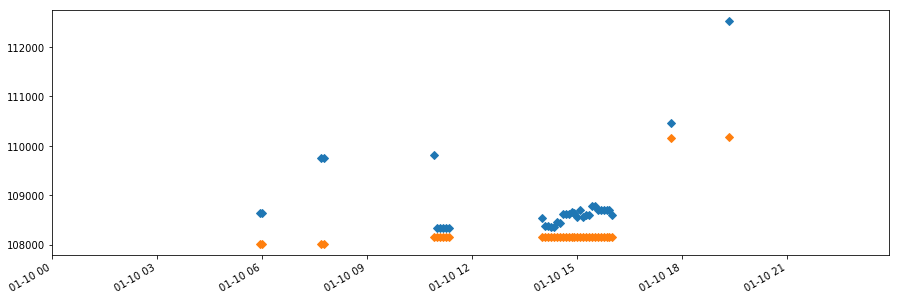

In [24]:
# Visualizing the data for a given type makes it clearer where the profitable regions lie.
#
ax = acceptable_bids[acceptable_bids.type_id == 5955].target.plot(style="D", figsize=[15,5])
acceptable_bids[acceptable_bids.type_id == 5955].bid.plot(style="D")
ax.set_xlim(datetime.datetime(2017,1,10,0,0,0), datetime.datetime(2017,1,10,23,55,0))

Target price \(blue diamonds\) changes throughout the day, while best bid \(orange diamonds\) stays constant until late in the day.  There are two regions where the target and best bid are close.  This suggests you would need to change your target bid about three times this day to stay near the best bid, but not exceed the target price.

In [25]:
# As you might expect, results are sensitive to target return.  Let's lower our target by 1%
# to see the difference.
#
acceptable_bids = find_acceptable_bids(order_book, promising_types, source_types, station_id, region_id, efficiency, 
                                       tax_rate, station_tax, broker_fee, desired_return - 0.01, verbose=True)

Checking 288 snapshots for bids
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



In [26]:
# The five available types do not change
#
import pprint
type_query = "{values: [" + ",".join([str(x) for x in acceptable_bids.type_id.unique()]) + "]}"
type_list = Client.SDE.load_complete(sde_client.Inventory.getTypes, typeID=type_query)
pprint.pprint([x['typeName'] for x in type_list])

['500MN Cold-Gas Enduring Microwarpdrive',
 '100MN Monopropellant Enduring Afterburner',
 '100MN Y-S8 Compact Afterburner',
 '500MN Y-T8 Compact Microwarpdrive',
 '500MN Quad LiF Restrained Microwarpdrive']


(736339.0, 736339.9965277778)

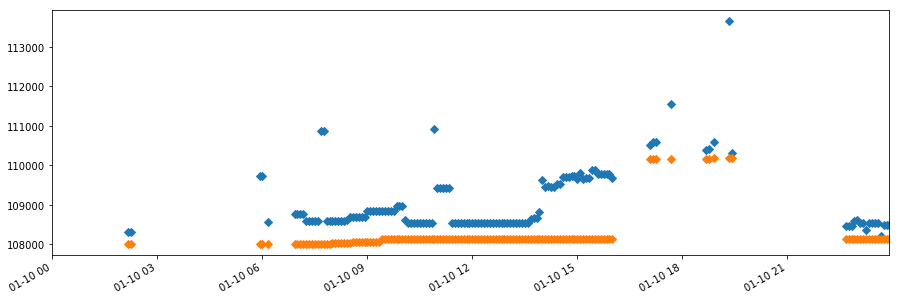

In [27]:
# However, the range over which our sample type is profitable is much larger.
#
ax = acceptable_bids[acceptable_bids.type_id == 5955].target.plot(style="D", figsize=[15,5])
acceptable_bids[acceptable_bids.type_id == 5955].bid.plot(style="D")
ax.set_xlim(datetime.datetime(2017,1,10,0,0,0), datetime.datetime(2017,1,10,23,55,0))

Lowering the return target further will likely increase the profitability range again, and may admit other types as well.

We've only considered one day of history in this example.  A proper analysis would consider a longer time range before concluding that certain types can be traded profitably with limit buy orders.  Also, we have only considered scrapmetal processing, whereas similar opportunities may be available for ore and ice types.  We leave these straightforward variants as exercises for the reader.